# AQT Optimizations with Qiskit

<a target="_blank" href="https://colab.research.google.com/github/SupertechLabs/client-superstaq/blob/main/docs/source/optimizations/aqt/aqt_qss.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/>
</a>
<a target="_blank" href="https://mybinder.org/v2/gh/SupertechLabs/client-superstaq/HEAD?labpath=docs/source/optimizations/aqt/aqt_qss.ipynb">
  <img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder" align="left" style="margin-left: 10px;"/>
</a>

Below is a brief tutorial on SuperstaQ optimizations for the Advanced Quantum Testbed (AQT), a superconducting transmon quantum computing testbed at Lawrence Berkeley National Laboratory. For more information on AQT, visit their website [here](https://www.sandia.gov/quantum/quantum-information-sciences/projects/qscout/).

## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Cirq; you can try it out by running `pip install qiskit-superstaq[examples]`:

In [1]:
# %pip install -q qiskit-superstaq[examples]

To generate the plots, you'll also need a local installation of `qtrl`, the control software suite for the Qantum Nanoelectronics Laboratory (QNL) at the University of California, Berkeley.

In [2]:
import numpy as np
import qiskit
import qiskit_superstaq as qss

# import matplotlib
# matplotlib.interactive(True)
import IPython

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaQProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaQProvider()` or by setting it as an environment variable (see more details [here](https://docs-superstaq.readthedocs.io/en/latest/get_started/basics.html#Set-up-access-to-SuperstaQ%E2%80%99s-API))

In [3]:
# Get the qiskit superstaq provider
provider = qss.SuperstaQProvider()

Superstaq supports two control hardware configurations for AQT: Keysight and Zurich, corresponding to the Superstaq targets "aqt_keysight_qpu" and "aqt_zurich_qpu". We can use either of these to instantiate a Superstaq backend for compilation:

In [4]:
# Get a Supestaq backend for AQT compilation for Keysight control hardware
keysight_backend = provider.get_backend("aqt_keysight_qpu")

# Get a Supestaq backend for AQT compilation for Zurich control hardware
zurich_backend = provider.get_backend("aqt_zurich_qpu")

For simplicity, we will use the Keysight backend throughout most of this tutorial:

In [5]:
backend = keysight_backend

## Configuration

Superstaq's compilation endpoint for AQT is deeply integrated with the `qtrl` control software suite. We use your qtrl configs to determine what gates and qubits are available to the compiler, and to generate pulse sequences (`qtrl.sequencer.Sequence` objects) using the provided calibrations.

You can upload your YAML configuration files directly to Superstaq, or download previously-uploaded configs from the server:

In [6]:
# Download and save existing configs from the server (use `overwrite=True` to overwrite existing files, otherwise an error will be thrown if either file already exists locally)
provider.aqt_download_configs("tmp-pulses.yaml", "tmp-variables.yaml", overwrite=True)

# Upload new configs to the server
provider.aqt_upload_configs("tmp-pulses.yaml", "tmp-variables.yaml")

Pulses configuration saved to tmp-pulses.yaml.
Variables configuration saved to tmp-variables.yaml.


'Your AQT configuration has been updated'

You can also pass `qtrl.managers.PulseManager` and `qtrl.managers.VariableManager` objects directly to `aqt_upload_configs()`, in place of file paths. After uploading your configs, they will be saved to your account and used whenever you use Superstaq's compiler for AQT.

## Single circuit compilation

Let's start by creating an example cirq circuit that we will compile and optimize for the AQT.
As an initial example, we can construct a four-qubit circuit and pass it to Superstaq:

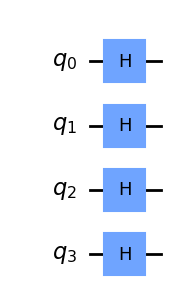

In [7]:
# Create a four-qubit uniform superposition
circuit1 = qiskit.QuantumCircuit(4)
circuit1.h([0, 1, 2, 3])

# Draw the input circuit
circuit1.draw("mpl")

We will now compile the circuit generated above to the AQT's hardware. The primary method for interfacing Superstaq's AQT toolchain is the `aqt_compile` endpoint:

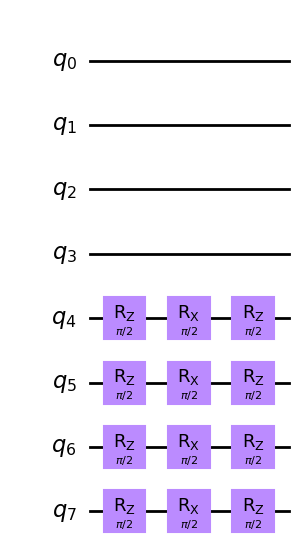

In [8]:
# Compile for AQT
compiler_output = backend.aqt_compile(circuit1)

# Call circuit from the compiler output to get the corresponding output circuit
compiler_output.circuit.draw("mpl")

The resulting output contains the same circuit compiled to AQT's native operations. Note that the original circuit was mapped to the active qubits on this device (by default qubits 4 through 8), and optimized to exploit AQT's use of virtual Z rotations (as opposed to the canonical Hadamard decomposition requiring two Rx(π/2) and a single Rz(π/2) gate, as described in [1]).

If you have `qtrl` installed locally and have already uploaded configs to Superstaq, the output will also contain the corresponding pulse sequence (an instance of `qtrl.sequencer.Sequence`):

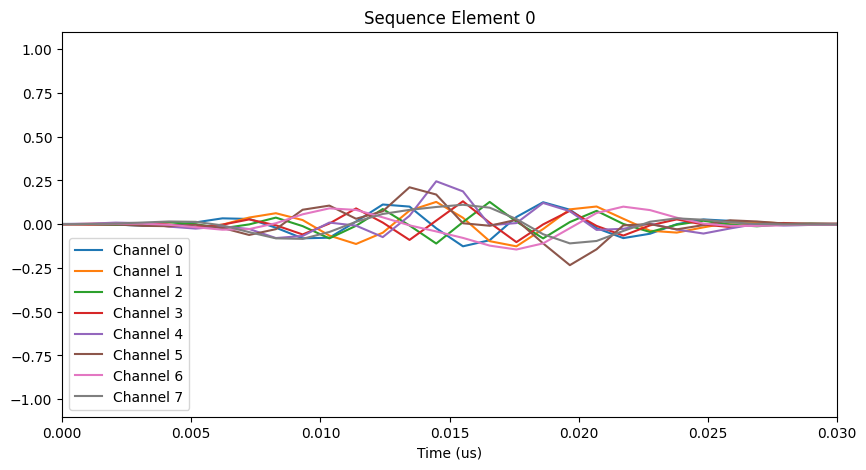

In [9]:
# Draw the corresponding pulse sequence (requires a local `qtrl` configuration, and config files uploaded to Superstaq)
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

We could also have used the Zurich backend to compile the same circuit. Notice the visible change in sample rate:

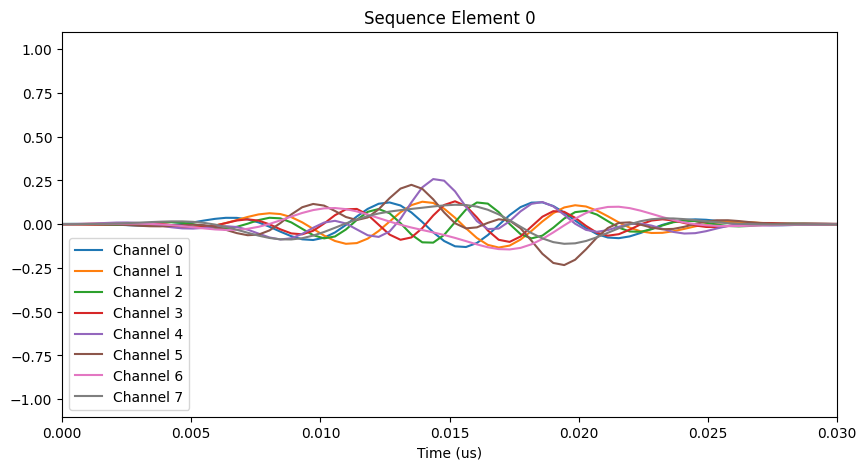

In [10]:
# Compile for AQT Zurich
compiler_output = zurich_backend.aqt_compile(circuit1)

# Draw the corresponding pulse sequence:
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

## Multiple circuit compilation

Superstaq's compilation endpoints also allow for the submission of multiple circuits. To illustrate this, let's create a second example circuit containing a single SWAP gate:

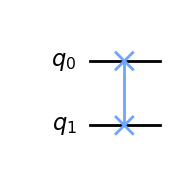

In [11]:
# Construct a SWAP circuit
circuit2 = qiskit.QuantumCircuit(2)
circuit2.swap(0, 1)

# Draw the circuit
circuit2.draw("mpl")

When a list of circuits is passed to `aqt_compile`, each will be individually compiled and the merged into a single `qtrl` pulse sequence object. The list of compiled circuits can be accessed via the compiler output's `.circuits` attribute:

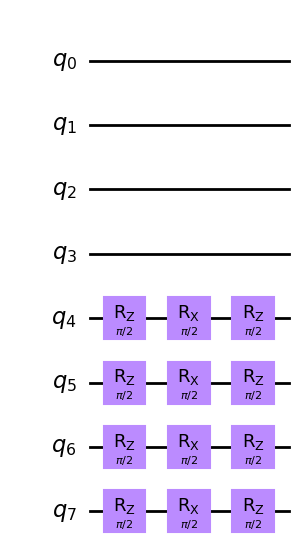

In [12]:
# Send both example circuits to Superstaq as a list
compiler_output = backend.aqt_compile([circuit1, circuit2])

# Draw the first compiled circuit
compiler_output.circuits[0].draw("mpl")

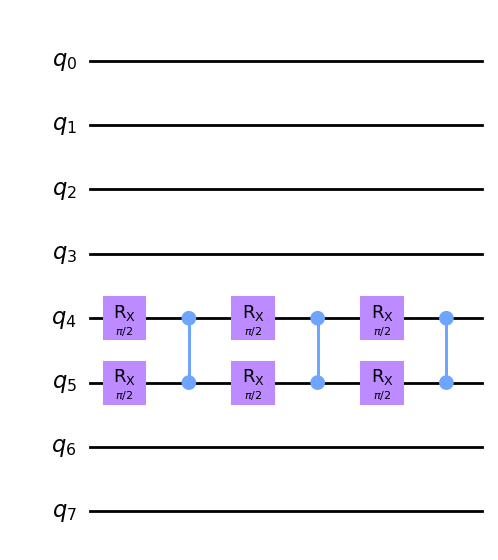

In [13]:
# Draw the second compiled circuit
compiler_output.circuits[1].draw("mpl")

Notice that the compiled SWAP circuit uses the optimized SWAP decomposition outlined in [1], which reduces circuit depth by parallelizing the outer single-qubit gates. This parallelization is also apparent in the corresponding pulse sequence (if available). When compiling multiple circuits, each pulse sequence can be accessed via the corresponding `element` of the combined `qtrl.sequencer.Sequence` object (assigned consecutively):

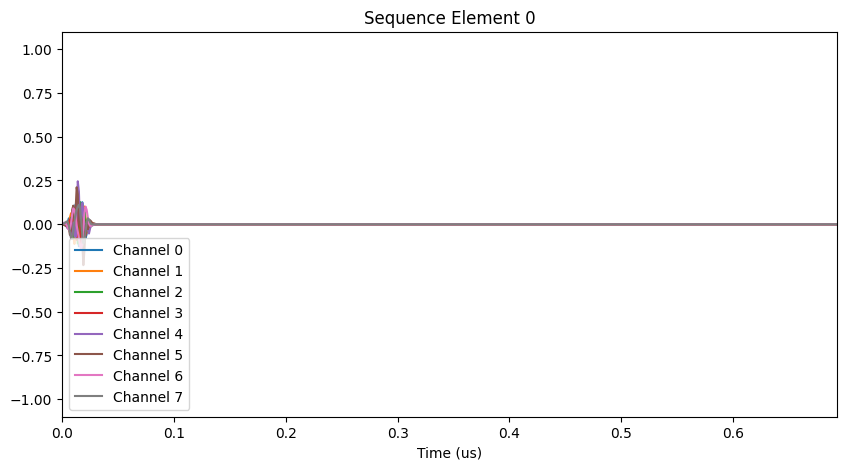

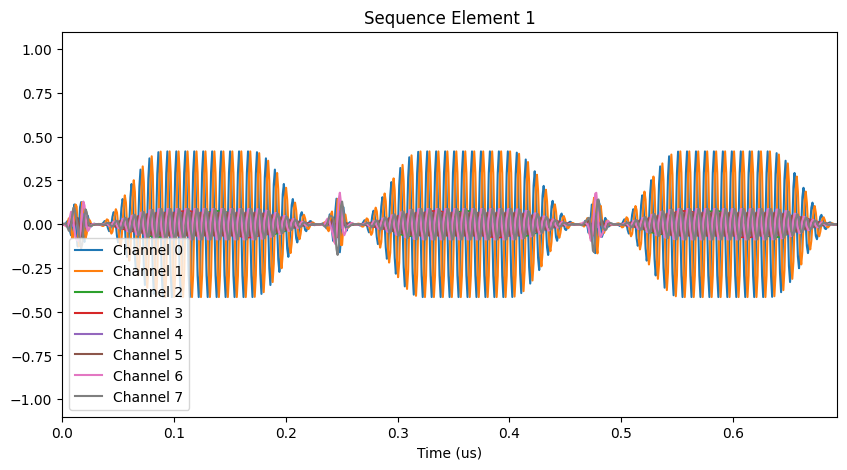

In [14]:
# Draw the corresponding pulse sequences (requires a local `qtrl` configuration, and config files uploaded to Superstaq):
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)  # pulse sequence corresponding to circuit1
    compiler_output.seq.plot(element=1)  # pulse sequence corresponding to circuit2

## Custom operations

Superstaq's compilation toolchain is designed to support a flexible set of native hardware operations. It will automatically recognize various AQT-specific hardware operations if corresponding calibrations exist in your pulse configuration, such as CS/CSD, iToffoli, or optimized calibrations for parallel CZ/CS operations. Custom gates defined in `qiskit-superstaq` are provided for those operations which do not exist in Cirq itself.

### iToffoli

The AQT iToffoli operation is defined as an open-control Toffoli gate with an additional CPhase(π/2) acting on the two control qubits (see [2]). You can instantiate it using the `qss.AQTiToffoliGate()` (or `qss.AQTiCCXGate()`) custom gate:

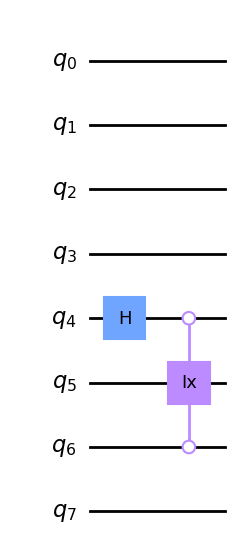

In [15]:
# Instantiate a circuit containing an AQT iToffoli targetting qubit 5 and controlled by qubits 4 and 6
circuit = qiskit.QuantumCircuit(8)
circuit.h(4)
circuit.append(qss.AQTiCCXGate(), [4, 6, 5])

# Draw the circuit
circuit.draw("mpl")

If a corresponding callibration is provided in your pulse configuration (under the key `"TOF"`), `aqt_compile` will recognize this operation instead of decomposing it into the standard gateset:

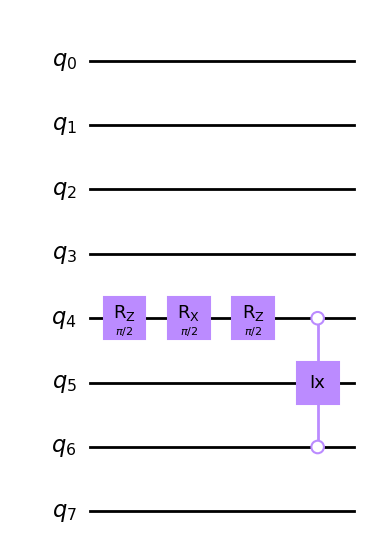

In [16]:
# Compile for AQT
compiler_output = backend.aqt_compile(circuit)

# Draw the compiled circuit
compiler_output.circuit.draw("mpl")

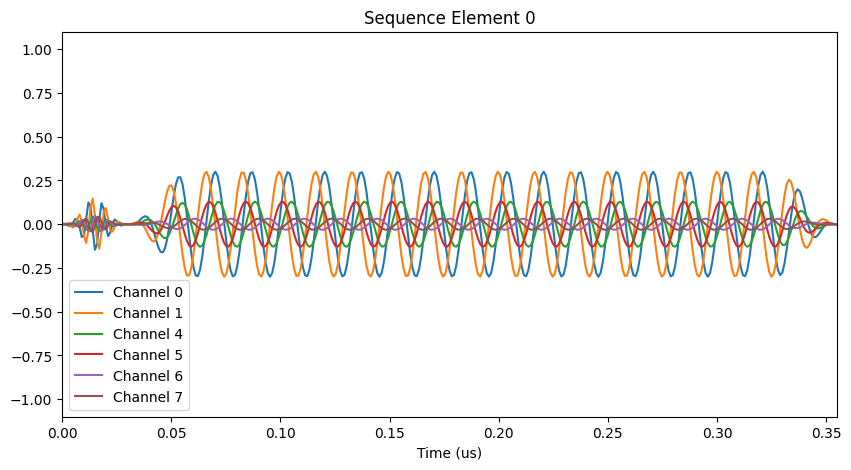

In [17]:
# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

### CS and CSD

The `aqt_compile` endpoint also has out-of-the-box support for controlled partial-rotation CPhase(±π/2) (i.e. "CS" and "CSD") gates. These can be invoked directly via `circuit.cp(±π/2)`, as in the following example. Note the smaller pulse amplitudes and durations of the CS and CSD operations relative to the CZs in the resulting pulse sequence:

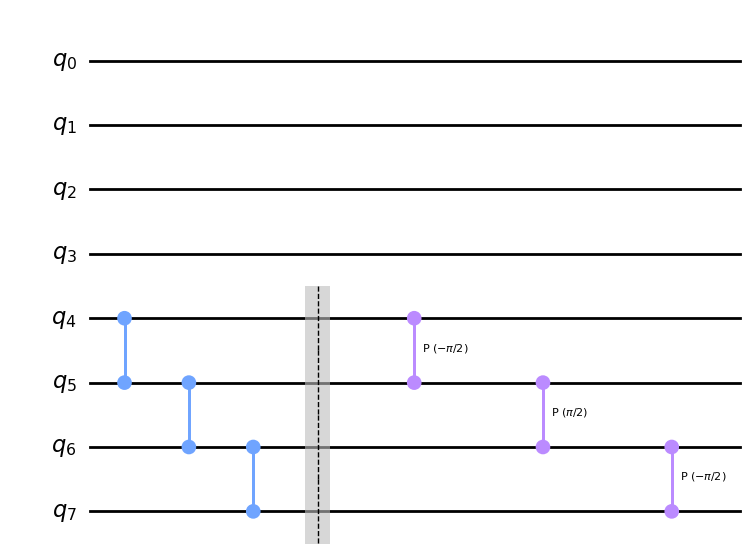

In [18]:
# Instantiate a circuit containing CZ, CS, and CSD operations
circuit = qiskit.QuantumCircuit(4)
circuit.cz(0, 1)
circuit.cz(1, 2)
circuit.cz(2, 3)
circuit.barrier()  # prevent optimizations or parallelization of gates across this barrier
circuit.cp(-0.5 * np.pi, 0, 1)
circuit.cp(0.5 * np.pi, 1, 2)
circuit.cp(-0.5 * np.pi, 2, 3)

# Compile for AQT
compiler_output = backend.aqt_compile(circuit)

# Draw the compiled circuit
compiler_output.circuit.draw("mpl")

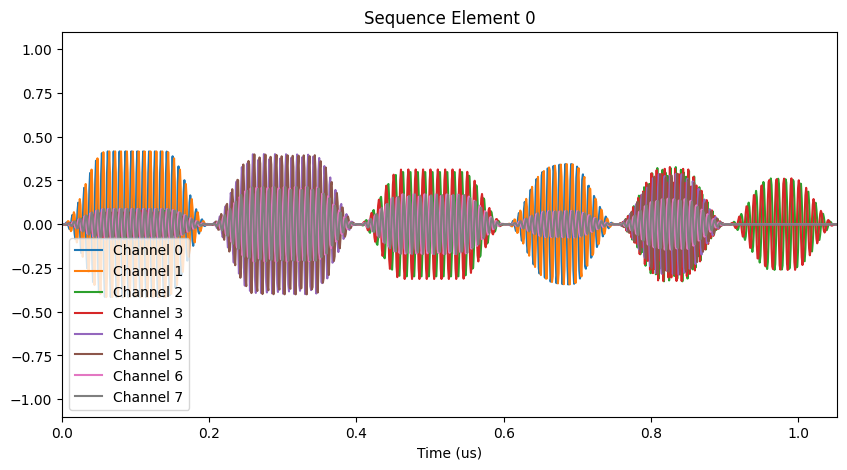

In [19]:
# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

These gates will also be inferred automatically when decomposing arbitrary circuits. For example, as described in [1], the ZZ-SWAP operation (also available as a custom gate in `qiskit-superstaq`) can for some angles be implemented with two CZs and a CS or CSD operation, instead of three CZs. Similarly, any controlled-rotation can be implemented using a pair of CS or CSD gates, instead of two CZs:

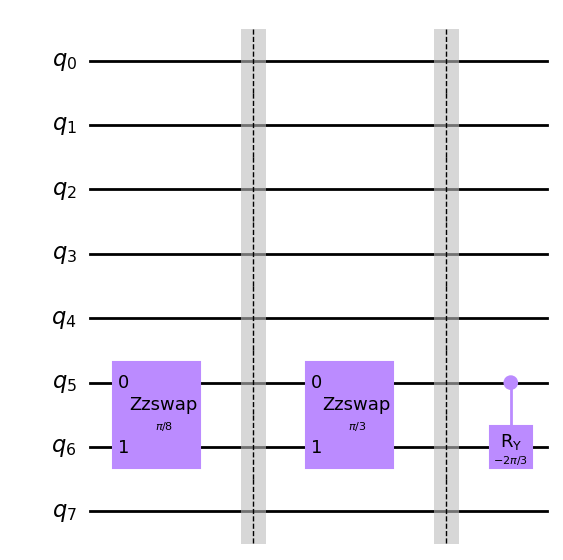

In [20]:
# The ZZ-SWAP(θ) gate requires 3 CZ gates for |θ| < π/4
circuit = qiskit.QuantumCircuit(8)
circuit.append(qss.ZZSwapGate(np.pi / 8), [5, 6])

# For π/4 <= |θ| <= 3π/4, the ZZ-SWAP(θ) gate can be implemented using two CZs and a CS (or CSD)
circuit.barrier()
circuit.append(qss.ZZSwapGate(np.pi / 3), [5, 6])

# Controlled-SU(2) gates can always be implemented using two CS or CSD gates
circuit.barrier()
circuit.cry(-2 * np.pi / 3, 5, 6)

# Draw the input circuits
circuit.draw("mpl")

When these operations are compiled with `aqt_compile`, Superstaq will automatically recognize the cases in employing CS or CSD gates results in a more efficient decomposition:

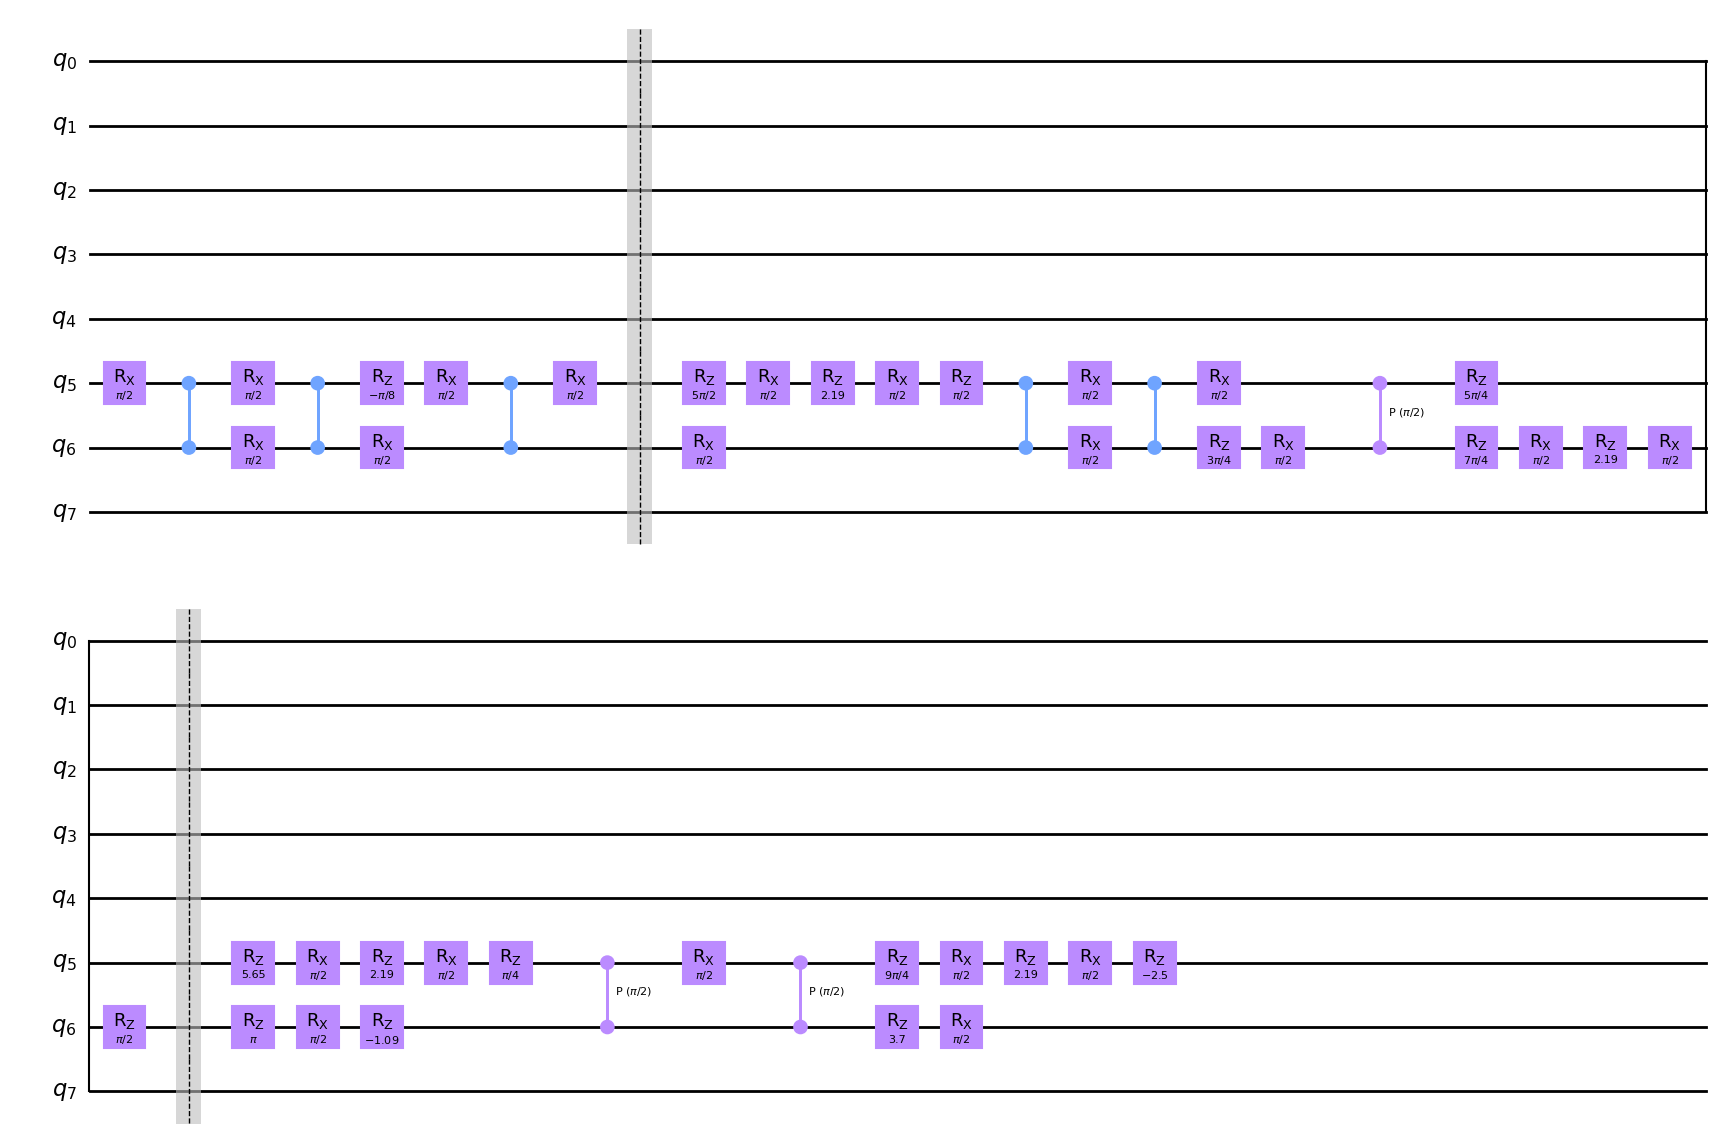

In [21]:
# Compile for AQT
compiler_output = backend.aqt_compile(circuit)

compiler_output.circuit.draw("mpl")

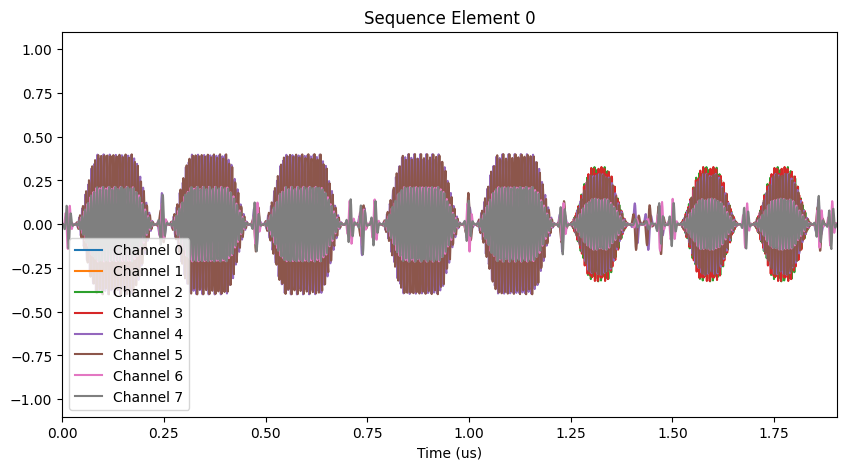

In [22]:
# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

### Simultaneous CZs and CSDs

The `aqt_compile` endpoint also supports optimized callibrations for parallel CZ and CS/CSD operations [1]. These are inferred automatically by the compiler, or can be invoked directly using `qiskit-superstaq`'s custom `ParallelGates` operation:

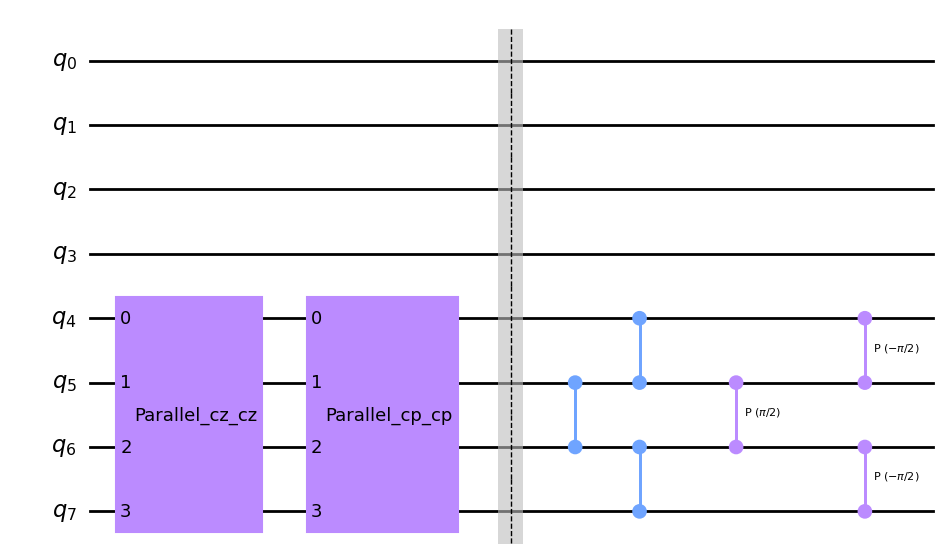

In [23]:
# Directly instantiated parallel operations:
circuit = qiskit.QuantumCircuit(8)
circuit.append(
    qss.ParallelGates(qiskit.circuit.library.CZGate(), qiskit.circuit.library.CZGate()),
    [4, 5, 6, 7],
)
circuit.append(
    qss.ParallelGates(
        qiskit.circuit.library.CPhaseGate(-np.pi / 2), qiskit.circuit.library.CPhaseGate(-np.pi / 2)
    ),
    [4, 5, 6, 7],
)

circuit.barrier()

# Implicitly instantiated parallel operations:
circuit.cz(5, 6)
circuit.cz(4, 5)
circuit.cz(6, 7)
circuit.cp(np.pi / 2, 5, 6)
circuit.cp(-np.pi / 2, 4, 5)
circuit.cp(-np.pi / 2, 6, 7)

# Draw the input circuit
circuit.draw("mpl")

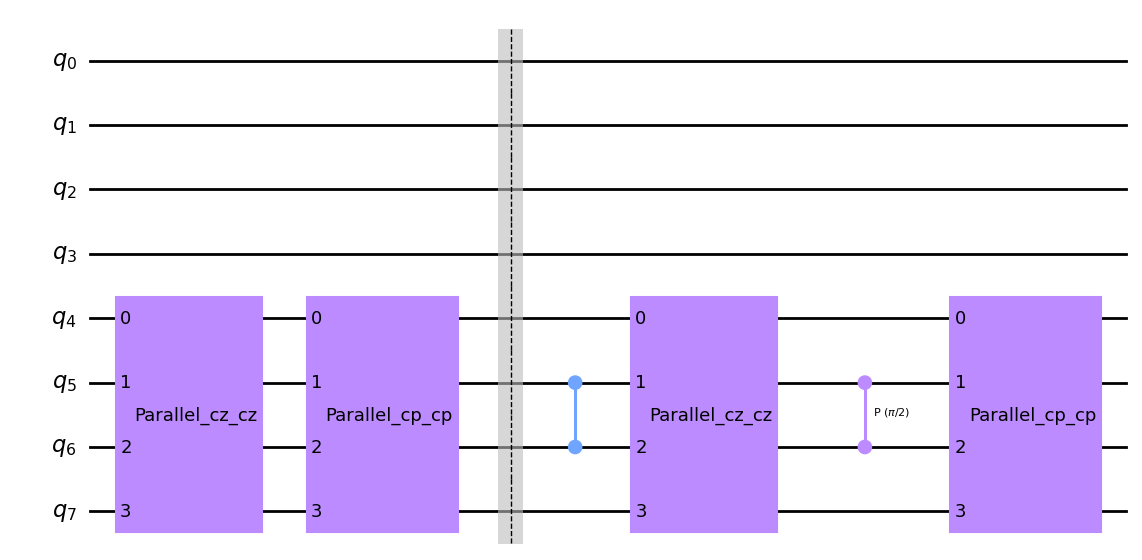

In [24]:
# Compile for AQT
compiler_output = backend.aqt_compile(circuit)

# Draw the compiled circuit
compiler_output.circuit.draw("mpl")

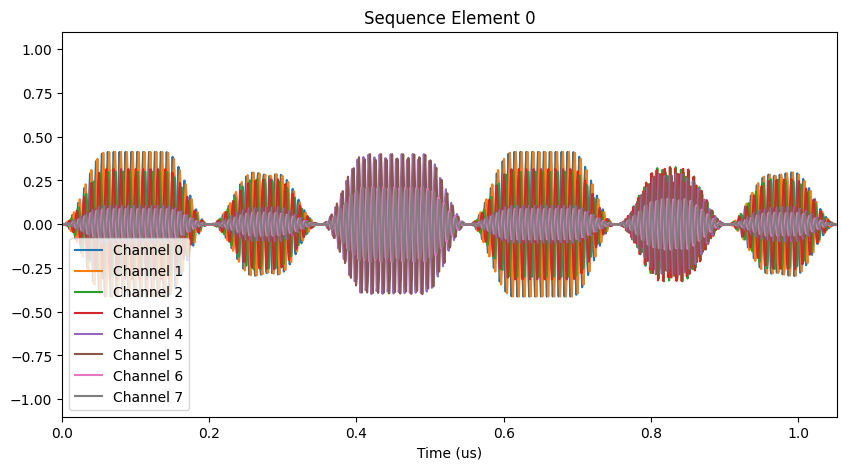

In [25]:
# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

When compiling arbitrary circuits, `aqt_compile` will also attempt to align and merge any gates resulting from the decomposition and optimization of the input circuit if an optimized parallel calibration exists. As an example, we can place two of the ZZ-SWAP gates used in the previous example on adjacent pairs of qubits:

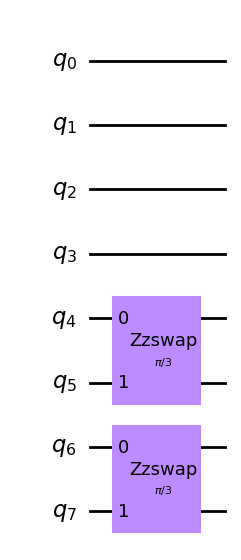

In [26]:
# Build a circuit with two ZZ-SWAP operations in parallel
circuit = qiskit.QuantumCircuit(8)
circuit.append(qss.ZZSwapGate(np.pi / 3), [4, 5])
circuit.append(qss.ZZSwapGate(np.pi / 3), [6, 7])

# Draw the circuit
circuit.draw("mpl")

When we compile this circuit with `aqt_compile`, the corresponding CZ and CSD operations of each operation will be merged into `qss.ParallelGates` operations in the compiled circuit, and the corresponding optimized calibration will be used in the resulting pulse sequence:

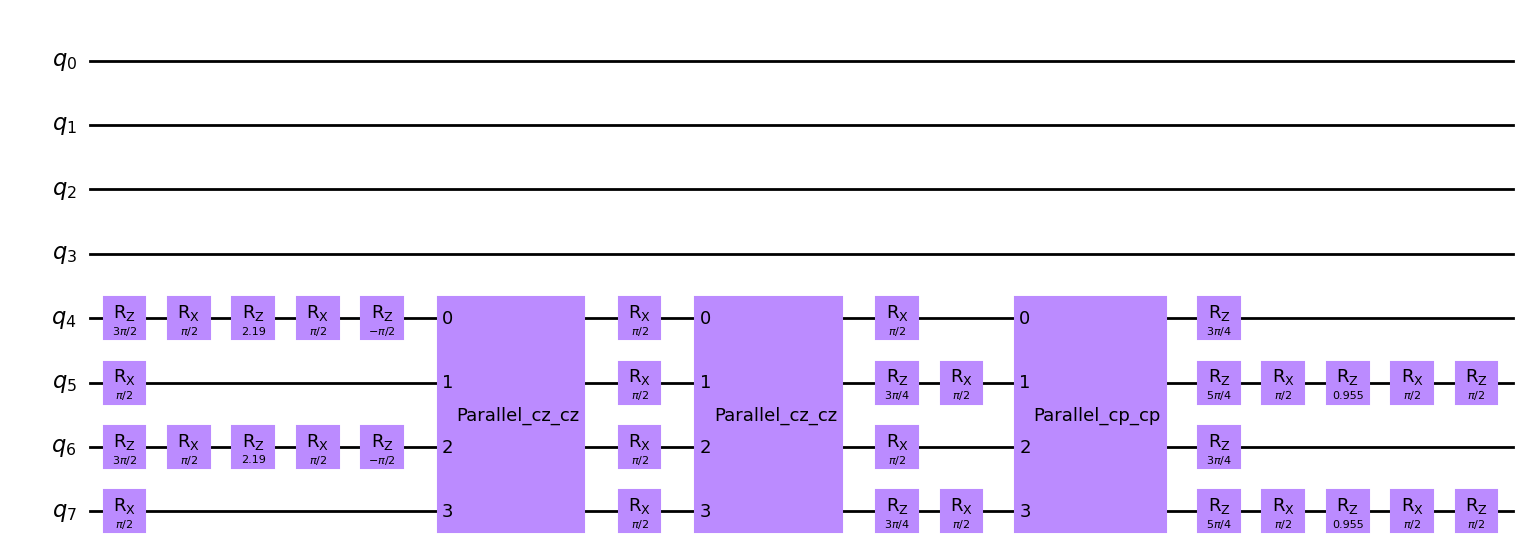

In [27]:
# Compile for AQT
compiler_output = backend.aqt_compile(circuit)

# Draw the compiled circuit
compiler_output.circuit.draw("mpl")

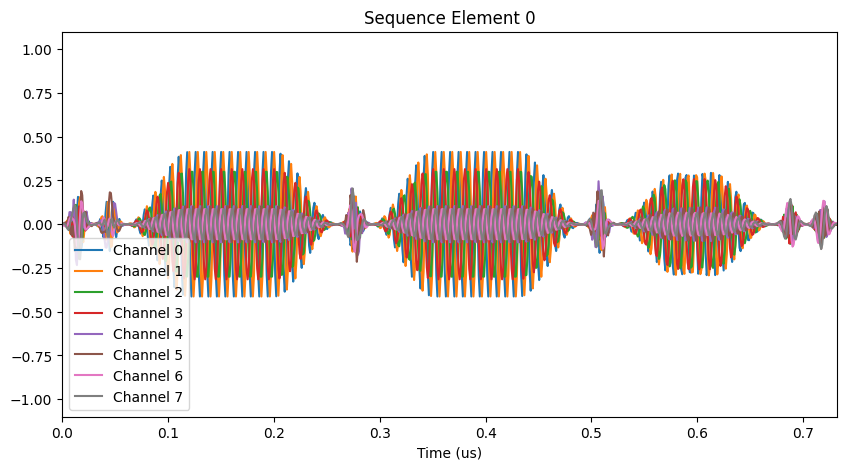

In [28]:
# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

### Bring Your Own

In addition to the predefined gates described above, you can assign arbitrary gate definitions to pulse sequence `aqt_compile` via its `gate_defs=` argument. To demonstrate this functionality, let's start with a pair of controlled rotation gates (which we've already seen can be implemented with two CS or CSD operations):

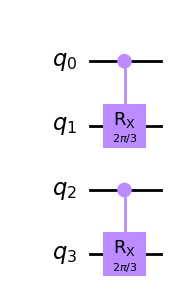

In [29]:
# Construct a circuit with a pair of controlled-X rotations
circuit = qiskit.QuantumCircuit(4)
circuit.crx(2 * np.pi / 3, 0, 1)
circuit.crx(2 * np.pi / 3, 2, 3)

# Draw the input circuit
circuit.draw("mpl")

Now, say we had \*intended\* to tune up a couple of CSD gates, but our calibrations weren't perfect and so in practice these operations are under-rotated a bit. We can use `gate_defs` to tell `aqt_compile` the \*actual\* physical gates implemented by the calibrations in our pulse configuration, which will then be used when compiling the provided circuit. The definitions in `gate_defs` can be arbitrary unitary matrices. For the purposes of this illustration, we will also override the CZ and CS calibrations to prevent the compiler from using them:

In [30]:
# Define the actual, under-rotated physical gates implemented by the CSD calibrations in our pulse configuration
gate_defs = {
    "CSD/C5T4": np.diag(
        [1.0, np.exp(0.1j), np.exp(-0.1j), np.exp(-0.45j * np.pi)]
    ),  # Gate implemented by our "CSD" calibration for qubits 4 and 5
    "CSD/C7T6": np.diag(
        [1.0, np.exp(0.1j), np.exp(-0.1j), np.exp(-0.35j * np.pi)]
    ),  # Gate implemented by our "CSD" calibration for qubits 6 and 7
    "CZ": None,  # Prevent compiler from using any of the "CZ" calibrations in our pulse config
    "CS": None,  # Prevent compiler from using any of the "CS" calibrations in our pulse config
}

When we pass `gate_defs` to `aqt_compile` alongside the input circuit, we see that it now uses the correct operations for each pair of qubits in the compiled circuit:

In [31]:
# Compile for AQT
compiler_output = backend.aqt_compile(circuit, gate_defs=gate_defs)

# Draw the compiled circuit
compiler_output.circuit.draw("mpl")

# ...and the corresponding pulse sequence
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)

SuperstaQException: Status code: 400, Message: 'Non-retriable error making request to SuperstaQ API, Invalid gate definition for 'CSD/C5T4'..

If you would like to contact a member of our team, email us at superstaq@infleqtion.com or join our Slack workspace: https://join.slack.com/t/superstaq/shared_invite/zt-1wr6eok5j-fMwB7dPEWGG~5S474xGhxw'

## Equivalent circuit averaging (ECA)

SuperstaQ provides an additional second endpoint for equivalent circuit averaging (also introduced in [1]). Using the `num_equivalent_circuits` argument for `aqt_compile`, a single input circuit can be compiled into a set of logically equivalent but physically distinct pulse sequences.

### Example: single-qubit gate decomposition

As a preliminary example, let's consider the decomposition of a single-qubit gate. Arbitrary SU(2) operations can be implemented on AQT using two Rx(π/2) pulses. Two such decompositions exist, which will be selected at random if `num_equivalent_circuits` is set:

In [ ]:
# Constuct a circuit containing a randomly-selected an operation in SU(2)
circuit = qiskit.QuantumCircuit(1)
circuit.u(*np.random.uniform(-np.pi, np.pi, size=3), 0)

# Use SuperstaQ to generate 5 logically-equivalent circuits for ECA
compiler_output = backend.aqt_compile(circuit, num_equivalent_circuits=5, random_seed=1234)

# Draw the each compiled circuit
for compiled_circuit in compiler_output.circuits:
    compiled_circuit.draw("mpl")
    print()

We can also confirm that the corresponding pulse sequences are physically distinct:

In [ ]:
# Draw the two distinct pulse sequences
if compiler_output.seq is not None:
    compiler_output.seq.plot(element=0)
    compiler_output.seq.plot(element=2)

### Example: ZZ-SWAP

For a more illuminating example, let's again consider the ZZ-SWAP gate used above (which allows for implementation using two CZs and a single CS operation). The compiled circuit returned in that example is far from unique; in fact there a great many physically distinct implementations it could have chosen. This is made apparent when compiling the circuit using `aqt_compile_eca`:

In [ ]:
# Construct a circuit with a single one-qubit gate
circuit = qiskit.QuantumCircuit(4)
circuit.append(qss.ZZSwapGate(1.23), [1, 2])

# Draw the input circuit
print("Input circuit:")
circuit.draw("mpl")

# Use SuperstaQ to generate 5 equivalent circuits using ECA compilation
compiler_output = backend.aqt_compile(circuit, num_equivalent_circuits=5, random_seed=1234)


# Print the equivalent circuits and pulse sequences
print("\n\nEquivalent compiled circuits:")
for i in range(5):
    compiler_output.circuits[i].draw("mpl")
    print()
    print()

We can see many differences between the compiled circuits above, such as whether the CS gate comes before or after the two CZ gates, which qubits the Rx(π/2) gates are applied to in each moment, and the virtual phases applied to each qubit between these operations. These all result in physical distinctions between the corresponding pulse sequences:

In [ ]:
# Draw the two distinct pulse sequences
if compiler_output.seq is not None:
    for element in range(5):
        compiler_output.seq.plot(element=element)